<a href="https://colab.research.google.com/github/Taeho-Kim-0322/Deep_Learning_Start/blob/master/%EC%8B%A4%EC%8A%B5_3_2_RNN_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EA%B8%B0%EB%B3%B8%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(🎧) 표시가 되어 있는 부분은 Wire 페이지에서 오디오 코드 해설을 제공하고 있습니다.

---

# 실습 3. RNN을 이용한 😀감정분석😑 모델 학습하기



<b>학습 목표:    
- TensorFlow를 사용해 RNN을 활용한 텍스트분류 모델을 만들 수 있다.   
- 기 확보된 워드벡터를 사용해 임베딩을 초기화할 수 있다. 
</b>








## #0. 실습 준비하기
먼저 구글 드라이브를 마운트하고, 드라이브에 저장해두었던 데이터를 로딩하겠습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


konlpy에서 사용하는 jpype를 설치하고, Colab에 반영해 주어야 합니다.   
아래 코드를 실행한 후 상단의 [런타임] - [런타임 다시 시작]을 클릭해주세요.

In [ ]:
!pip install konlpy
!pip install jpype1==0.7.0

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 52.5MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 2.7MB 5.9MB/s 
  Found existing installation: JPype1 1.2.0
    Uninstalling JPype1-1.2.0:
      Successfully uninstalled JPype1-1.2.0


In [ ]:
## train, validation, test 데이터 로딩
!cp "/content/gdrive/My Drive/NLP/utils.py" "/content"

import pickle
import numpy as np
with open("/content/gdrive/My Drive/NLP/Sentiment_prepro_data.pkl", "rb") as f:
  prepro_data = pickle.load(f)
train_ids = prepro_data["train_ids"]
train_labels = prepro_data["train_labels"]
val_ids = prepro_data["val_ids"]
val_labels = prepro_data["val_labels"]
test_ids = prepro_data["test_ids"]
test_labels = prepro_data["test_labels"]
label_map = prepro_data["label_map"]
print(len(train_ids), len(train_labels), len(val_ids), len(val_labels), len(test_ids), len(test_labels))

49998 49998 10000 10000 10000 10000


In [ ]:
""" 한국어 형태소 분석 라이브러리 """
from konlpy.tag import Komoran
 
komoran = Komoran()
 
def tokenize(sentence):
  return komoran.morphs(sentence)
 
tokenize("미션 완료!!")

['미션', '완료', '!!']

In [ ]:
## 단어사전 & text_encoder 로딩
from utils import TextEncoder
import json
with open("/content/gdrive/My Drive/NLP/Sentiment_vocab.json", "r") as f:
  new_vocab_list = json.loads(f.read())

text_encoder = TextEncoder(new_vocab_list)

In [ ]:
""" CBOW 워드벡터 로딩 """

## final_embeddings: 70002개 토큰에 대한 워드 벡터 매트릭스 shape=(70002, 128)

with open("/content/gdrive/My Drive/NLP/vecs.tsv") as f:
  vecs = [v.strip() for v in f.readlines()]
  final_embeddings = [v.split("\t") for v in vecs]
  final_embeddings = np.array(final_embeddings, dtype="float32")

## #1. 모델 만들기
<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step3+4.PNG?raw=true">

#### Step 1. 모델 구조 만들기
이제 실습 소개에서 보았던 모델 아키텍처를 tensorflow를 사용해 만들어보겠습니다.   
아래의 Summary를 보고 직접 모델을 한 번 만들어보세요.

<font color="red">MISSION : model의 summary를 확인하고 tf.keras.Sequential을 이용해 이와 동일한 모델을 만들어 보세요.   
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding (Embedding)        (None, None, 128)         10993664  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                8950      
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
=================================================================
Total params: 11,005,266
Trainable params: 11,005,266
Non-trainable params: 0
_________________________________________________________________
```
</font>


In [ ]:
## 쌓여있는 불필요한 것들을 삭제
import tensorflow as tf
tf.keras.backend.clear_session()

<조건(🎧)>   
1. Embedding: vocab_size -> embedding_dim으로 임베딩, Padding된 부분은 마스킹할 것 (mask_zero 옵션)
2. SimpleRNN의 유닛(hidden_size)은 50차원이 되게 할 것
3. 첫 번째 Dense layer에서는 relu activation을 사용할 것, hidden 차원은 50차원
4. 두 번째 Dense layer에서는 결과가 [긍정, 부정] 카테고리에 대한 확률값과 같이 나오도록 할 것

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

vocab_size = text_encoder.vocab_size # 단어사전 개수
embedding_dim = final_embeddings.shape[1] # 임베딩 차원
rnn_hidden_dim = 50 # RNN hidden_size
final_dim = len(label_map)

""" YOUR CODE HERE """

model = Sequential()
## 1. Embedding layer 추가 ... (주의) padding된 부분은 마스킹 필요 -> mask_zero 옵션 참고 ## [★CODE 1★]
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, mask_zero = True))

## 2. SimpleRNN 레이어 추가 ## [★CODE 2★]
model.add(SimpleRNN(rnn_hidden_dim))

## 3. Fully Connected Layer 추가 (RNN 아웃풋에 대한 정보 가공) ## [★CODE 3★]
model.add(Dense(rnn_hidden_dim, activation = "relu"))

## 4. Fully Connected Layer 추가 (최종 태스크 수행을 위한 레이어) ## [★CODE 4★]
model.add(Dense(final_dim, activation = "softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         10987392  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                8950      
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 10,998,994
Trainable params: 10,998,994
Non-trainable params: 0
_________________________________________________________________


#### Step 2. CBOW로 학습된 워드 임베딩으로 모델 임베딩 Initialize 하기

In [ ]:
## 단어사전 개수 체크
org_vocab_size = final_embeddings.shape[0]
new_vocab_size = len(new_vocab_list)

print("CBOW initialize될 토큰 개수:", org_vocab_size)
print("새로운 임베딩의 one-hot-vector:", new_vocab_size, "\n")
print("-> 랜덤 초기화해야 할 벡터 차원: {} x {}".format(new_vocab_size-org_vocab_size, embedding_dim))


CBOW initialize될 토큰 개수: 70002
새로운 임베딩의 one-hot-vector: 85839 

-> 랜덤 초기화해야 할 벡터 차원: 15837 x 128


👉이번 모델의 임베딩에서 기존 CBOW로 학습된 워드벡터로 초기화할 부분을 제외한 나머지는 랜덤하게 초기화야 합니다.   
👉즉, <랜덤 초기화해야 할 벡터 차원>에 있는 만큼의 매트릭스를 랜덤 initialize해야 하지요.

numpy를 사용해 Uniform~[-1, 1]으로부터 랜덤 초기화된 워드벡터를 생성하겠습니다.

In [ ]:
rand_initial = np.random.uniform(-1,1,size=[vocab_size-org_vocab_size,embedding_dim])
rand_initial.shape

(15837, 128)

그리고, CBOW로 학습된 final_embeddings 뒤에    
방금 초기화한 rand_initial 매트릭스를 이어붙여 임베딩 매트릭스를 만들겠습니다. 

numpy 패키지의 append 기능을 사용하면 됩니다.

In [ ]:
initial_weight = np.append(final_embeddings, rand_initial, axis = 0)
initial_weight.shape

(85839, 128)

👉initial_weight는 이번 모델의 임베딩 매트릭스 차원과 같은 것을 확인할 수 있습니다.   

(🎧)이제 model의 weight에 우리가 만든 initial_weight를 할당하도록 하겠습니다. 

model.weight에 assign 함수를 사용하면 이 작업을 쉽게 할 수 있습니다.   


In [ ]:
model.weights[0].assign(initial_weight) # model.weights[0] -> 임베딩 레이어에 해당
model.get_weights()[0]

array([[-0.01368477, -0.02725928, -0.02415868, ..., -0.00882053,
        -0.0210129 ,  0.04017795],
       [-0.18259747,  0.13225454, -0.40374675, ..., -0.24515007,
         0.5843183 ,  0.41799858],
       [-0.21374829,  0.17352384,  0.4282032 , ...,  0.8664426 ,
        -0.13740769, -0.5702798 ],
       ...,
       [ 0.49861586, -0.03549137,  0.74748164, ...,  0.84299487,
         0.24528289,  0.92614007],
       [ 0.6286997 ,  0.5318246 ,  0.04617601, ...,  0.8422901 ,
        -0.64247733,  0.06996694],
       [ 0.43504035,  0.5890022 ,  0.31281134, ...,  0.13570197,
        -0.01109538, -0.8355334 ]], dtype=float32)

In [ ]:
final_embeddings

array([[-0.01368477, -0.02725928, -0.02415868, ..., -0.00882053,
        -0.0210129 ,  0.04017795],
       [-0.18259747,  0.13225454, -0.40374675, ..., -0.24515007,
         0.5843183 ,  0.41799858],
       [-0.21374829,  0.17352384,  0.4282032 , ...,  0.8664426 ,
        -0.13740769, -0.5702798 ],
       ...,
       [ 0.02406064, -0.00335619,  0.03366775, ..., -0.16383906,
        -0.02016309,  0.10198709],
       [-0.13832492, -0.16530281,  0.03323587, ..., -0.12326222,
         0.00226797, -0.07895309],
       [ 0.15055574, -0.22581291,  0.17770346, ..., -0.2334886 ,
        -0.12006498,  0.13866542]], dtype=float32)

#### Step 3. 모델 컴파일하기

<font color="red">MISSION : 적절한 Loss 함수와 Optimizer을 선택하고, "accuracy" 매트릭을 트래킹하도록 컴파일해주세요
</font>

In [ ]:
""" Your Code Here """
model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = "accuracy")


#### Step 4. 모델 학습하기 (🎧)
모델 구조 선언과 컴파일이 완료되었습니다!    
이제 model.fit()을 통해 학습을 진행하겠습니다.    
이때 validation data의 loss를 트래킹하며 loss가 증가할 시 EarlyStopping을 하는 콜백을 사용하겠습니다.

In [ ]:
## early stopping callback 정의
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=1)

In [ ]:
num_epochs = 5
history = model.fit(train_ids, train_labels, epochs=num_epochs, batch_size=200,
                    validation_data=(val_ids, val_labels), callbacks=[callback])

Epoch 1/5
250/250 [==============================] - 26s 103ms/step - loss: 0.5767 - accuracy: 0.6810 - val_loss: 0.4298 - val_accuracy: 0.8009
Epoch 2/5
250/250 [==============================] - 26s 104ms/step - loss: 0.3806 - accuracy: 0.8339 - val_loss: 0.4094 - val_accuracy: 0.8158
Epoch 3/5
250/250 [==============================] - 26s 103ms/step - loss: 0.3024 - accuracy: 0.8762 - val_loss: 0.4246 - val_accuracy: 0.8047


#### Step 5. 훈련 결과 진단하기

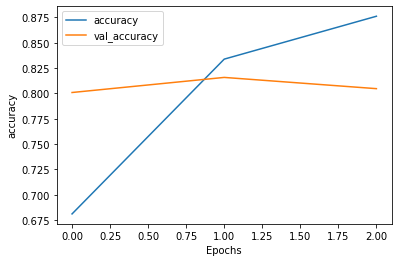

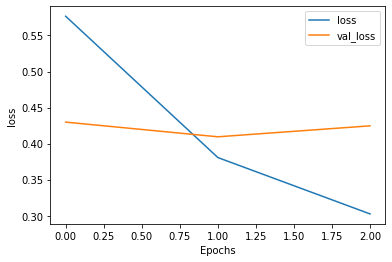

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
## Test Set에서의 accuracy 측정
model.evaluate(test_ids, test_labels)

313/313 [==============================] - 2s 7ms/step - loss: 0.4267 - accuracy: 0.8085


[0.426712304353714, 0.8084999918937683]

## #2. Inference 실행하기
이제 학습이 완료된 모델로 새로운 문장에 대해 추론을 해보겠습니다.

In [ ]:
""" 훈련된 모델로 다시 예측해보기 """

def inference(mymodel, sentence):
  # 1. tokenizer로 문장 파싱
  parsed_sent = tokenize(sentence)

  # 2. vocab_dict를 이용해 인덱스로 변환
  input_id1 = text_encoder.convert_tokens_to_ids(parsed_sent)
  
  # 단일 문장 추론이기 때문에 패딩할 필요가 없음
  input_id = np.array([input_id1])
  score = mymodel.predict(input_id)  #[1, 2]

  print("** INPUT:", sentence)
  print("   -> 긍정: {:.2f} / 부정: {:.2f}".format(score[0][0],score[0][1]))

In [ ]:
inference(model, "올해의 영화!!! 최고!!!")

** INPUT: 올해의 영화!!! 최고!!!
   -> 긍정: 0.97 / 부정: 0.03


In [ ]:
inference(model, "내가 감독해도 이거보단 낫겠네")

** INPUT: 내가 감독해도 이거보단 낫겠네
   -> 긍정: 0.08 / 부정: 0.92


<font color="blue">🙋‍♀️최근에 본 영화를 떠올리며 감상평을 써보세요! 모델이 잘 분류하는지 테스트해봅시다
</font>

In [ ]:
inference(model, "2회차 관람 예약이용 ㅠ")

** INPUT: 2회차 관람 예약이용 ㅠ
   -> 긍정: 0.44 / 부정: 0.56
